[Epoch 1/30] [Batch 0/469] [D loss: 1.0846] [G loss: 0.4497]
[Epoch 1/30] [Batch 100/469] [D loss: 0.3772] [G loss: 2.2158]
[Epoch 1/30] [Batch 200/469] [D loss: 0.1835] [G loss: 1.8290]
[Epoch 1/30] [Batch 300/469] [D loss: 0.1283] [G loss: 2.1525]
[Epoch 1/30] [Batch 400/469] [D loss: 0.0999] [G loss: 2.3927]


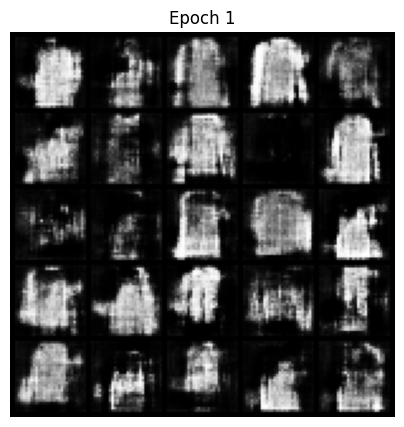

[Epoch 2/30] [Batch 0/469] [D loss: 0.1538] [G loss: 2.0803]
[Epoch 2/30] [Batch 100/469] [D loss: 0.2635] [G loss: 1.3966]
[Epoch 2/30] [Batch 200/469] [D loss: 0.1743] [G loss: 1.7261]
[Epoch 2/30] [Batch 300/469] [D loss: 0.2523] [G loss: 3.0032]
[Epoch 2/30] [Batch 400/469] [D loss: 0.2757] [G loss: 1.1951]


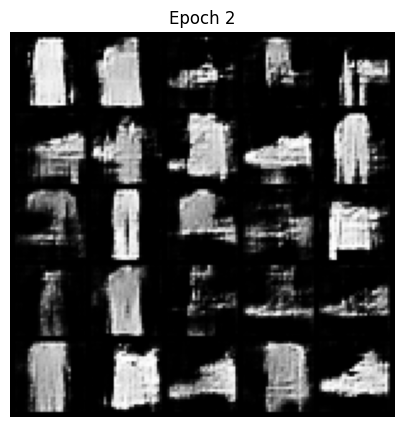

[Epoch 3/30] [Batch 0/469] [D loss: 0.3817] [G loss: 2.7891]
[Epoch 3/30] [Batch 100/469] [D loss: 0.2857] [G loss: 2.3272]
[Epoch 3/30] [Batch 200/469] [D loss: 0.2889] [G loss: 1.4857]
[Epoch 3/30] [Batch 300/469] [D loss: 0.3217] [G loss: 1.3116]
[Epoch 3/30] [Batch 400/469] [D loss: 0.3983] [G loss: 2.0299]


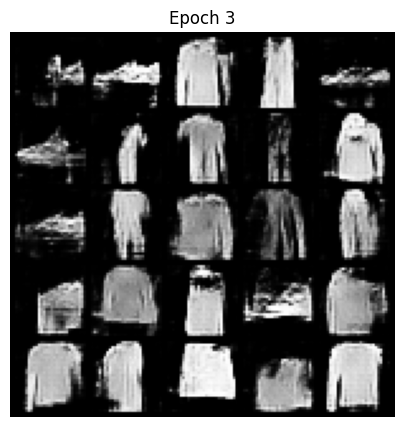

[Epoch 4/30] [Batch 0/469] [D loss: 0.3751] [G loss: 2.1104]
[Epoch 4/30] [Batch 100/469] [D loss: 0.3607] [G loss: 0.9759]
[Epoch 4/30] [Batch 200/469] [D loss: 0.3300] [G loss: 1.3800]
[Epoch 4/30] [Batch 300/469] [D loss: 0.4299] [G loss: 0.8189]
[Epoch 4/30] [Batch 400/469] [D loss: 0.5289] [G loss: 2.6486]


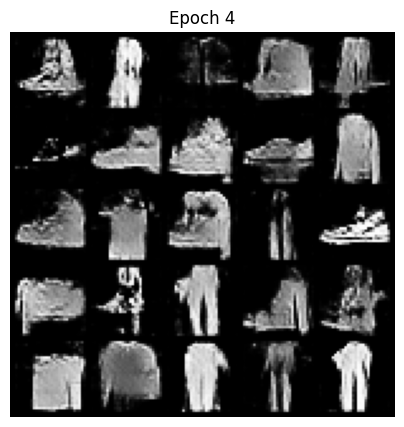

[Epoch 5/30] [Batch 0/469] [D loss: 0.4579] [G loss: 0.7770]
[Epoch 5/30] [Batch 100/469] [D loss: 0.3864] [G loss: 1.2815]
[Epoch 5/30] [Batch 200/469] [D loss: 0.3925] [G loss: 1.2638]
[Epoch 5/30] [Batch 300/469] [D loss: 0.5014] [G loss: 0.9885]
[Epoch 5/30] [Batch 400/469] [D loss: 0.4062] [G loss: 1.4319]


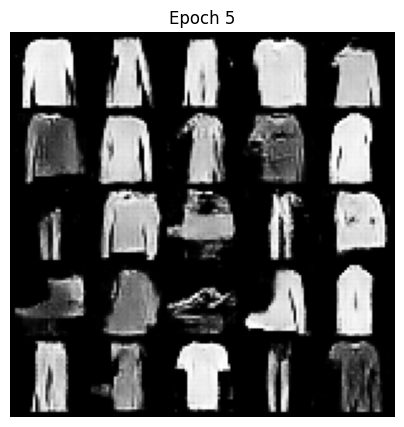

[Epoch 6/30] [Batch 0/469] [D loss: 0.3908] [G loss: 1.2906]
[Epoch 6/30] [Batch 100/469] [D loss: 0.3945] [G loss: 1.3653]
[Epoch 6/30] [Batch 200/469] [D loss: 0.3794] [G loss: 1.3349]
[Epoch 6/30] [Batch 300/469] [D loss: 0.4148] [G loss: 1.4210]
[Epoch 6/30] [Batch 400/469] [D loss: 0.3877] [G loss: 1.4053]


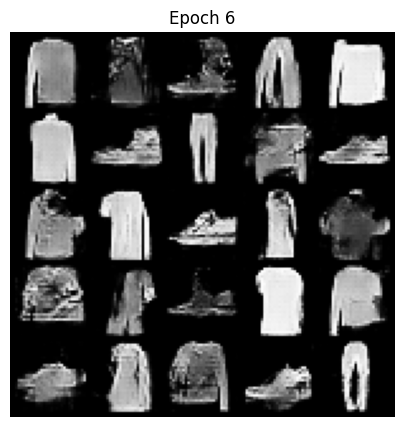

[Epoch 7/30] [Batch 0/469] [D loss: 0.4067] [G loss: 1.1119]
[Epoch 7/30] [Batch 100/469] [D loss: 0.4202] [G loss: 1.3732]
[Epoch 7/30] [Batch 200/469] [D loss: 0.4600] [G loss: 1.3039]
[Epoch 7/30] [Batch 300/469] [D loss: 0.4035] [G loss: 1.6595]
[Epoch 7/30] [Batch 400/469] [D loss: 0.4134] [G loss: 0.9450]


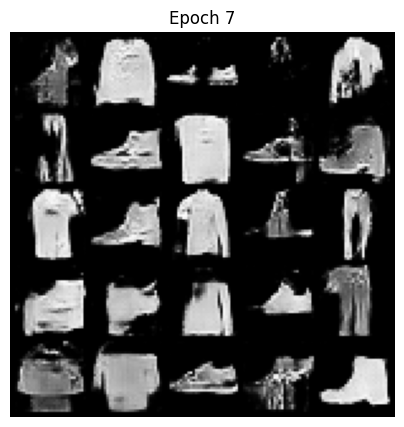

[Epoch 8/30] [Batch 0/469] [D loss: 0.4546] [G loss: 1.5466]
[Epoch 8/30] [Batch 100/469] [D loss: 0.4816] [G loss: 2.3719]
[Epoch 8/30] [Batch 200/469] [D loss: 0.4948] [G loss: 0.9450]
[Epoch 8/30] [Batch 300/469] [D loss: 0.4296] [G loss: 1.2573]
[Epoch 8/30] [Batch 400/469] [D loss: 0.5235] [G loss: 0.7433]


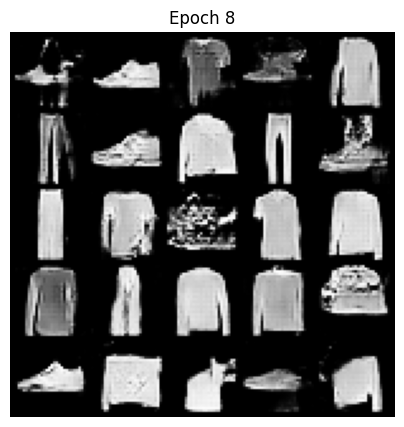

[Epoch 9/30] [Batch 0/469] [D loss: 0.4628] [G loss: 1.4453]
[Epoch 9/30] [Batch 100/469] [D loss: 0.4626] [G loss: 1.5019]
[Epoch 9/30] [Batch 200/469] [D loss: 0.4723] [G loss: 1.5083]
[Epoch 9/30] [Batch 300/469] [D loss: 0.4588] [G loss: 1.5163]
[Epoch 9/30] [Batch 400/469] [D loss: 0.4524] [G loss: 1.1370]


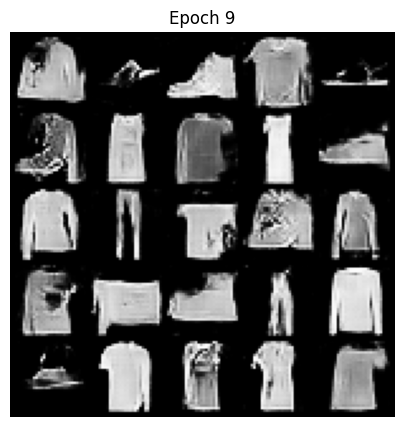

[Epoch 10/30] [Batch 0/469] [D loss: 0.3626] [G loss: 1.5363]
[Epoch 10/30] [Batch 100/469] [D loss: 0.4784] [G loss: 0.9640]
[Epoch 10/30] [Batch 200/469] [D loss: 0.4805] [G loss: 0.8949]
[Epoch 10/30] [Batch 300/469] [D loss: 0.5839] [G loss: 1.8576]
[Epoch 10/30] [Batch 400/469] [D loss: 0.5039] [G loss: 0.8144]


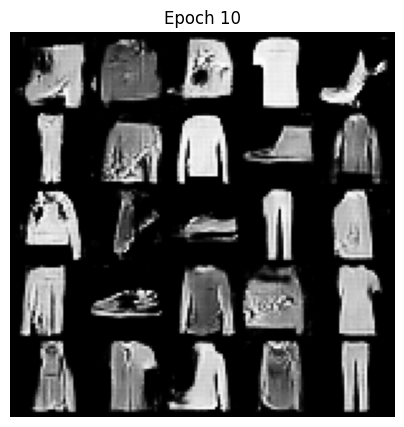

[Epoch 11/30] [Batch 0/469] [D loss: 0.4372] [G loss: 1.7652]
[Epoch 11/30] [Batch 100/469] [D loss: 0.4794] [G loss: 1.4563]
[Epoch 11/30] [Batch 200/469] [D loss: 0.4458] [G loss: 1.0238]
[Epoch 11/30] [Batch 300/469] [D loss: 0.4438] [G loss: 0.9979]
[Epoch 11/30] [Batch 400/469] [D loss: 0.5003] [G loss: 1.4863]


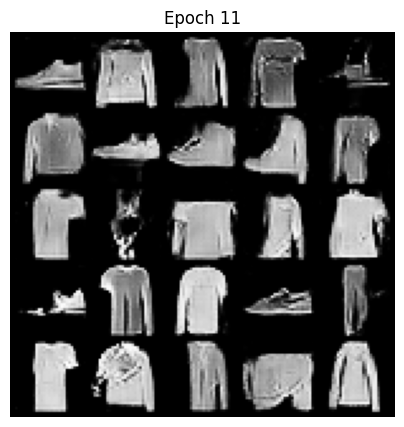

[Epoch 12/30] [Batch 0/469] [D loss: 0.5813] [G loss: 0.7418]
[Epoch 12/30] [Batch 100/469] [D loss: 0.4352] [G loss: 1.3963]
[Epoch 12/30] [Batch 200/469] [D loss: 0.4350] [G loss: 1.7795]
[Epoch 12/30] [Batch 300/469] [D loss: 0.4697] [G loss: 1.4414]
[Epoch 12/30] [Batch 400/469] [D loss: 0.5255] [G loss: 0.8503]


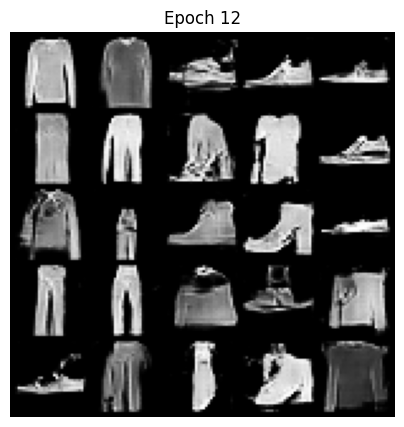

[Epoch 13/30] [Batch 0/469] [D loss: 0.4492] [G loss: 1.1959]
[Epoch 13/30] [Batch 100/469] [D loss: 0.4279] [G loss: 1.0987]
[Epoch 13/30] [Batch 200/469] [D loss: 0.5093] [G loss: 0.7720]
[Epoch 13/30] [Batch 300/469] [D loss: 0.5055] [G loss: 1.5411]
[Epoch 13/30] [Batch 400/469] [D loss: 0.5028] [G loss: 0.8724]


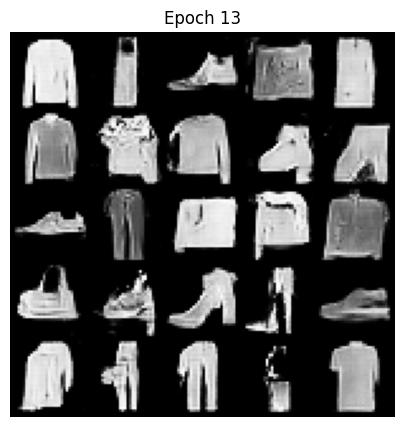

[Epoch 14/30] [Batch 0/469] [D loss: 0.4978] [G loss: 1.3598]
[Epoch 14/30] [Batch 100/469] [D loss: 0.5332] [G loss: 0.7997]
[Epoch 14/30] [Batch 200/469] [D loss: 0.5795] [G loss: 0.9398]
[Epoch 14/30] [Batch 300/469] [D loss: 0.5161] [G loss: 1.2235]
[Epoch 14/30] [Batch 400/469] [D loss: 0.5006] [G loss: 1.5614]


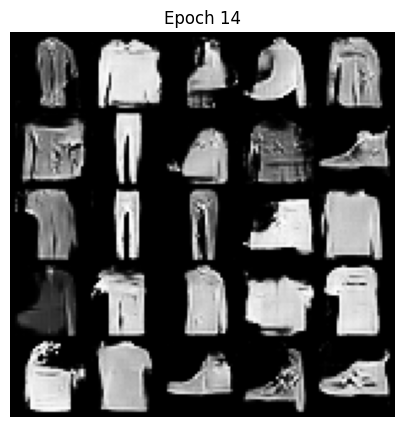

[Epoch 15/30] [Batch 0/469] [D loss: 0.4178] [G loss: 1.0885]
[Epoch 15/30] [Batch 100/469] [D loss: 0.5690] [G loss: 0.8486]
[Epoch 15/30] [Batch 200/469] [D loss: 0.4863] [G loss: 1.3330]
[Epoch 15/30] [Batch 300/469] [D loss: 0.5407] [G loss: 0.9431]
[Epoch 15/30] [Batch 400/469] [D loss: 0.5483] [G loss: 0.7075]


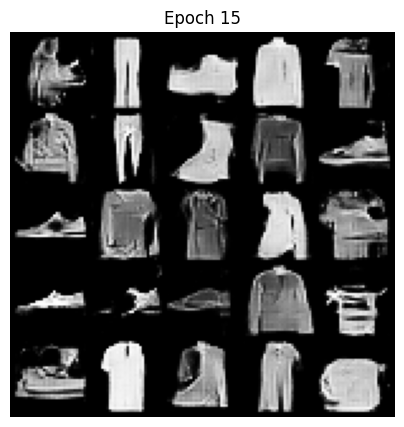

[Epoch 16/30] [Batch 0/469] [D loss: 0.5271] [G loss: 0.8085]
[Epoch 16/30] [Batch 100/469] [D loss: 0.4256] [G loss: 1.2175]
[Epoch 16/30] [Batch 200/469] [D loss: 0.5781] [G loss: 0.8387]
[Epoch 16/30] [Batch 300/469] [D loss: 0.4273] [G loss: 1.1437]
[Epoch 16/30] [Batch 400/469] [D loss: 0.4898] [G loss: 0.8115]


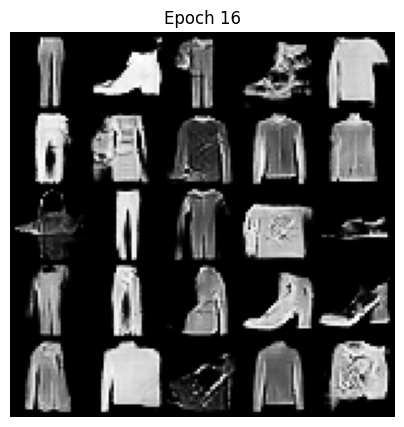

[Epoch 17/30] [Batch 0/469] [D loss: 0.4337] [G loss: 1.0158]
[Epoch 17/30] [Batch 100/469] [D loss: 0.5270] [G loss: 1.6939]
[Epoch 17/30] [Batch 200/469] [D loss: 0.5185] [G loss: 1.1978]
[Epoch 17/30] [Batch 300/469] [D loss: 0.4795] [G loss: 0.9021]
[Epoch 17/30] [Batch 400/469] [D loss: 0.4606] [G loss: 1.0754]


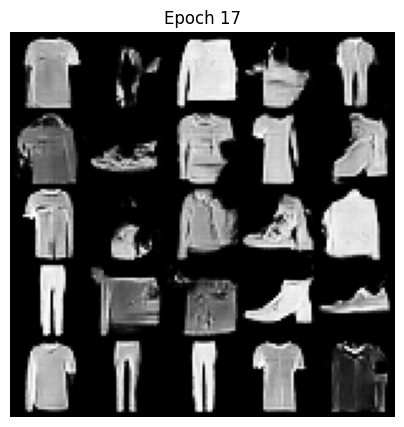

[Epoch 18/30] [Batch 0/469] [D loss: 0.5426] [G loss: 1.7399]
[Epoch 18/30] [Batch 100/469] [D loss: 0.5283] [G loss: 1.5877]
[Epoch 18/30] [Batch 200/469] [D loss: 0.4980] [G loss: 1.4411]
[Epoch 18/30] [Batch 300/469] [D loss: 0.5221] [G loss: 1.0271]
[Epoch 18/30] [Batch 400/469] [D loss: 0.5207] [G loss: 0.7652]


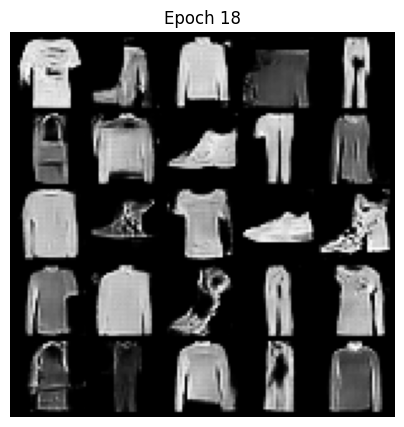

[Epoch 19/30] [Batch 0/469] [D loss: 0.4937] [G loss: 0.9470]
[Epoch 19/30] [Batch 100/469] [D loss: 0.5072] [G loss: 1.0102]
[Epoch 19/30] [Batch 200/469] [D loss: 0.4514] [G loss: 1.4033]
[Epoch 19/30] [Batch 300/469] [D loss: 0.4739] [G loss: 1.1569]
[Epoch 19/30] [Batch 400/469] [D loss: 0.4345] [G loss: 1.3374]


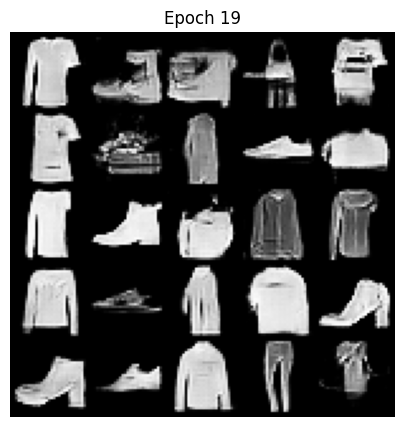

[Epoch 20/30] [Batch 0/469] [D loss: 0.5098] [G loss: 0.9139]
[Epoch 20/30] [Batch 100/469] [D loss: 0.6575] [G loss: 1.8112]
[Epoch 20/30] [Batch 200/469] [D loss: 0.4503] [G loss: 1.4163]
[Epoch 20/30] [Batch 300/469] [D loss: 0.4784] [G loss: 0.9746]
[Epoch 20/30] [Batch 400/469] [D loss: 0.5278] [G loss: 0.9640]


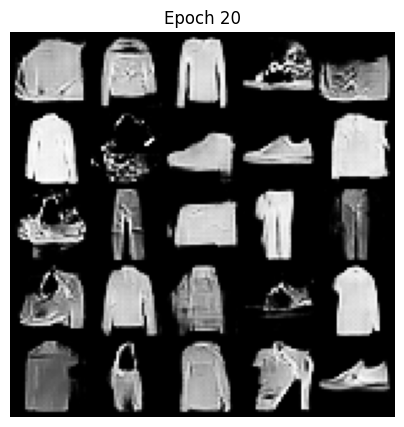

[Epoch 21/30] [Batch 0/469] [D loss: 0.5166] [G loss: 1.0725]
[Epoch 21/30] [Batch 100/469] [D loss: 0.4965] [G loss: 1.2513]
[Epoch 21/30] [Batch 200/469] [D loss: 0.4771] [G loss: 1.1044]
[Epoch 21/30] [Batch 300/469] [D loss: 0.4758] [G loss: 1.3230]
[Epoch 21/30] [Batch 400/469] [D loss: 0.4535] [G loss: 1.0662]


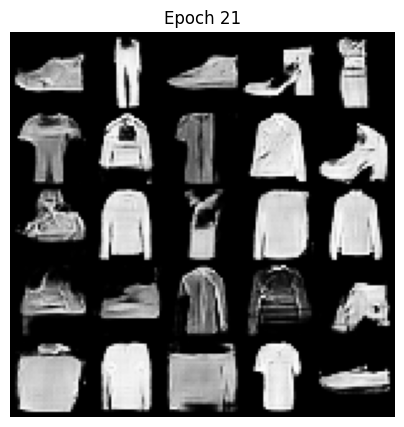

[Epoch 22/30] [Batch 0/469] [D loss: 0.5407] [G loss: 0.9715]
[Epoch 22/30] [Batch 100/469] [D loss: 0.4890] [G loss: 0.9281]
[Epoch 22/30] [Batch 200/469] [D loss: 0.6064] [G loss: 0.8690]
[Epoch 22/30] [Batch 300/469] [D loss: 0.6005] [G loss: 0.7383]
[Epoch 22/30] [Batch 400/469] [D loss: 0.5142] [G loss: 0.9651]


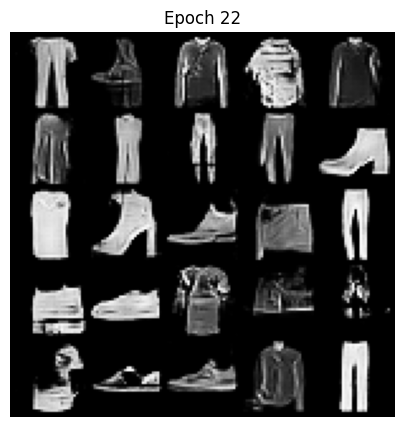

[Epoch 23/30] [Batch 0/469] [D loss: 0.4796] [G loss: 1.1224]
[Epoch 23/30] [Batch 100/469] [D loss: 0.4248] [G loss: 1.6071]
[Epoch 23/30] [Batch 200/469] [D loss: 0.5895] [G loss: 1.8392]
[Epoch 23/30] [Batch 300/469] [D loss: 0.5584] [G loss: 1.0695]
[Epoch 23/30] [Batch 400/469] [D loss: 0.5179] [G loss: 1.5673]


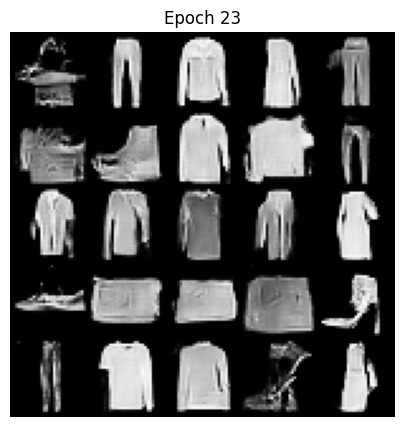

[Epoch 24/30] [Batch 0/469] [D loss: 0.5324] [G loss: 0.8583]
[Epoch 24/30] [Batch 100/469] [D loss: 0.5368] [G loss: 1.3885]
[Epoch 24/30] [Batch 200/469] [D loss: 0.4891] [G loss: 1.1271]
[Epoch 24/30] [Batch 300/469] [D loss: 0.5689] [G loss: 0.6272]
[Epoch 24/30] [Batch 400/469] [D loss: 0.5185] [G loss: 1.3247]


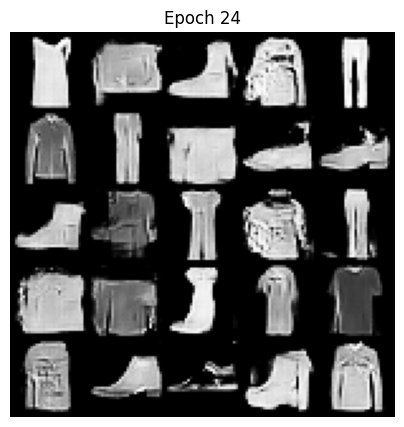

[Epoch 25/30] [Batch 0/469] [D loss: 0.5121] [G loss: 0.9636]
[Epoch 25/30] [Batch 100/469] [D loss: 0.5595] [G loss: 0.7346]
[Epoch 25/30] [Batch 200/469] [D loss: 0.5195] [G loss: 1.2667]
[Epoch 25/30] [Batch 300/469] [D loss: 0.5359] [G loss: 1.2913]
[Epoch 25/30] [Batch 400/469] [D loss: 0.4863] [G loss: 1.0226]


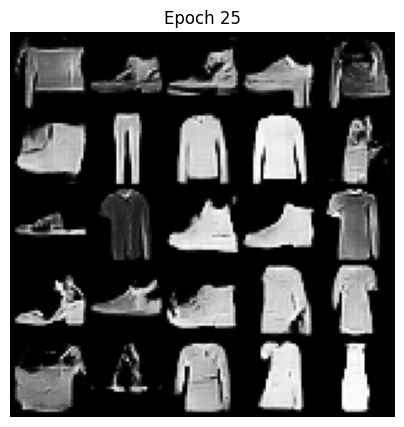

[Epoch 26/30] [Batch 0/469] [D loss: 0.4657] [G loss: 0.8732]
[Epoch 26/30] [Batch 100/469] [D loss: 0.4450] [G loss: 1.2729]
[Epoch 26/30] [Batch 200/469] [D loss: 0.5561] [G loss: 0.6828]
[Epoch 26/30] [Batch 300/469] [D loss: 0.5479] [G loss: 0.9048]
[Epoch 26/30] [Batch 400/469] [D loss: 0.4422] [G loss: 1.3651]


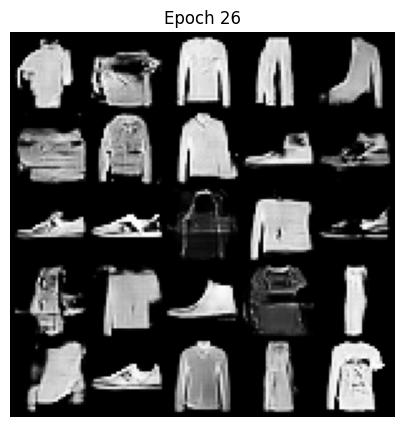

[Epoch 27/30] [Batch 0/469] [D loss: 0.5691] [G loss: 1.8028]
[Epoch 27/30] [Batch 100/469] [D loss: 0.5216] [G loss: 1.8067]
[Epoch 27/30] [Batch 200/469] [D loss: 0.4615] [G loss: 1.2818]
[Epoch 27/30] [Batch 300/469] [D loss: 0.4930] [G loss: 1.0591]
[Epoch 27/30] [Batch 400/469] [D loss: 0.4885] [G loss: 1.7021]


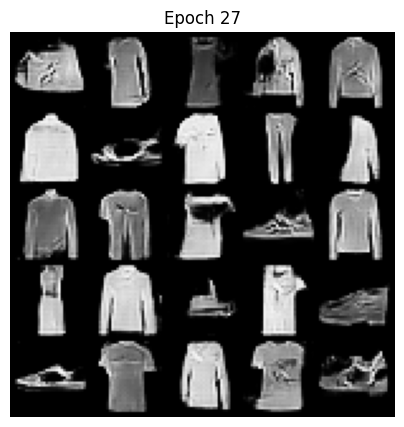

[Epoch 28/30] [Batch 0/469] [D loss: 0.4612] [G loss: 0.8754]
[Epoch 28/30] [Batch 100/469] [D loss: 0.5477] [G loss: 0.9665]
[Epoch 28/30] [Batch 200/469] [D loss: 0.4570] [G loss: 1.0715]
[Epoch 28/30] [Batch 300/469] [D loss: 0.5275] [G loss: 1.2452]
[Epoch 28/30] [Batch 400/469] [D loss: 0.4376] [G loss: 1.2209]


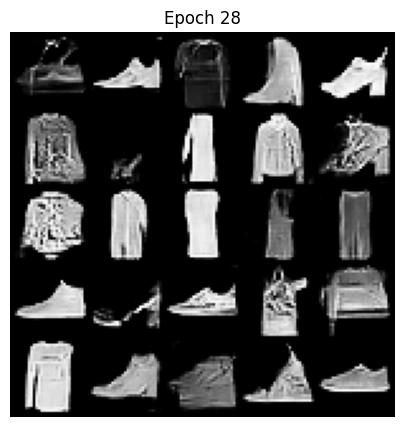

[Epoch 29/30] [Batch 0/469] [D loss: 0.5231] [G loss: 1.3736]
[Epoch 29/30] [Batch 100/469] [D loss: 0.5693] [G loss: 1.5613]
[Epoch 29/30] [Batch 200/469] [D loss: 0.4775] [G loss: 1.2664]
[Epoch 29/30] [Batch 300/469] [D loss: 0.4272] [G loss: 1.0175]
[Epoch 29/30] [Batch 400/469] [D loss: 0.4701] [G loss: 1.3403]


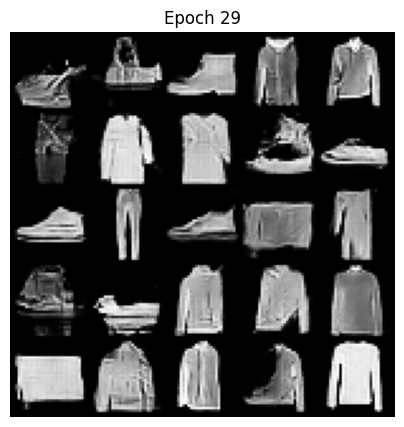

[Epoch 30/30] [Batch 0/469] [D loss: 0.5091] [G loss: 1.6575]
[Epoch 30/30] [Batch 100/469] [D loss: 0.4963] [G loss: 1.1343]
[Epoch 30/30] [Batch 200/469] [D loss: 0.6027] [G loss: 0.8558]
[Epoch 30/30] [Batch 300/469] [D loss: 0.4587] [G loss: 1.1075]
[Epoch 30/30] [Batch 400/469] [D loss: 0.5394] [G loss: 0.7675]


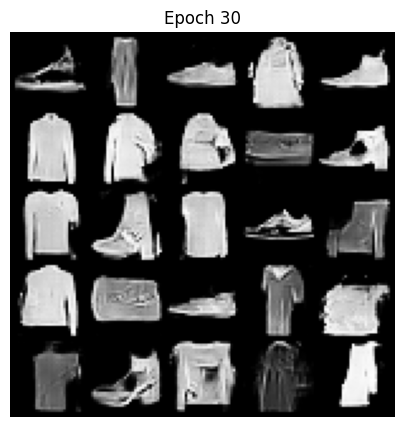

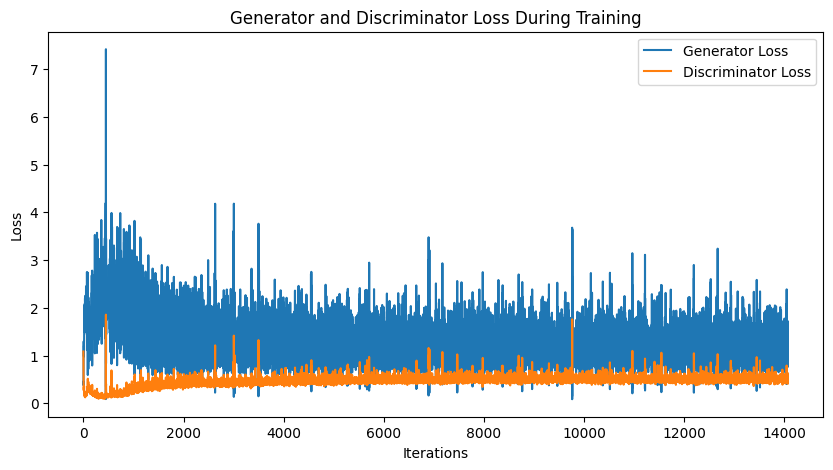

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 1. Environment Setup and Hyperparameter Definition
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
lr = 0.0002
num_epochs = 30
z_dim = 100  # Dimension of the latent space

# 2. Loading and Preprocessing the Dataset (FashionMNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
])
dataset = dsets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 3. Implementing the Generator Model for DCGAN (Using CNN)
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, feature_map_g=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: (z_dim, 1, 1)
            nn.ConvTranspose2d(z_dim, feature_map_g * 2, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_map_g * 2),
            nn.ReLU(True),
            # Output: (feature_map_g*2, 7, 7)
            nn.ConvTranspose2d(feature_map_g * 2, feature_map_g, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_map_g),
            nn.ReLU(True),
            # Output: (feature_map_g, 14, 14)
            nn.ConvTranspose2d(feature_map_g, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Adjust output to the range [-1, 1]
            # Final output: (img_channels, 28, 28)
        )
    def forward(self, x):
        return self.net(x)

# 4. Implementing the Discriminator Model for DCGAN (Using CNN)
class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_map_d=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Input: (img_channels, 28, 28)
            nn.Conv2d(img_channels, feature_map_d, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (feature_map_d, 14, 14)
            nn.Conv2d(feature_map_d, feature_map_d * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_map_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: (feature_map_d*2, 7, 7)
            nn.Conv2d(feature_map_d * 2, 1, kernel_size=7, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # Output: (1, 1, 1) which is then flattened to (batch, 1)
        )
    def forward(self, x):
        x = self.net(x)
        return x.view(-1, 1)

# 5. Creating the Models and Allocating Them to the Device
generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

# 6. Loss Function and Optimizers Setup
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# 7. Weight Initialization (Initialize all Convolution layers with a normal distribution: mean 0, std 0.02)
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 8. Training Process
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        batch_size_i = imgs.size(0)

        valid = torch.ones((batch_size_i, 1), device=device)
        fake = torch.zeros((batch_size_i, 1), device=device)

        real_imgs = imgs.to(device)

        # ----- Train Generator -----
        optimizer_G.zero_grad()
        # Generate random noise in the shape (z_dim, 1, 1) from the latent space
        z = torch.randn(batch_size_i, z_dim, 1, 1, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # ----- Train Discriminator -----
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(data_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # Visualize generated images at the end of each epoch
    generator.eval()
    with torch.no_grad():
        fixed_noise = torch.randn(25, z_dim, 1, 1, device=device)
        gen_imgs = generator(fixed_noise)
    generator.train()

    gen_imgs = (gen_imgs + 1) / 2  # Convert from [-1,1] to [0,1]
    grid = torchvision.utils.make_grid(gen_imgs, nrow=5, padding=2, normalize=False)
    np_grid = grid.cpu().numpy().transpose((1, 2, 0))

    plt.figure(figsize=(5,5))
    plt.imshow(np_grid)
    plt.title(f"Epoch {epoch+1}")
    plt.axis('off')
    plt.show()

# Visualize loss curves after training
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
